In [1]:
import pandas as pd
import sklearn.model_selection as sklm
import numpy as np
import math

import srd

import matplotlib.pyplot as plt

In [2]:
# Load a data table with pandas

df=pd.read_csv('srd_example.csv',index_col=0,header=0)

df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
O1,5.5,9,6,6,6,7,0,9,9,1.0,6.6
O2,2.0,4,2,2,2,3,1,3,3,0.0,2.3
O3,8.0,13,9,9,9,10,3,13,10,0.0,10.0
O4,11.5,20,18,17,16,24,0,24,24,0.0,17.9
O5,4.0,6,2,4,6,5,0,6,6,1.5,4.4
O6,7.0,1,8,8,8,4,1,1,4,0.0,4.0
O7,4.0,5,4,4,5,6,0,6,6,0.0,4.4
O8,12.0,1,15,15,12,1,2,1,1,1.0,7.0
O9,5.0,8,6,5,7,8,0,8,7,0.0,5.8
O10,11.0,18,15,17,15,15,5,20,20,1.0,15.7


In [6]:
# Core SRD calculation, implemented in srd.py as *srd_core(df,ref,normalize=True)*
# This block can be simply called as srd_values=srd.srd_core(df,ref), the rest is for illustrative purposes

# Define the reference vector. Can be either of the column names, or the following keywords
# corresponding to data fusion options: min, max, mean, median

ref='mean'

# Calculate the reference vector

refVector=srd.calc_ref(df,ref)

# Rank transform the input table and the reference vector, calculate the differences and the SRD values.

dfr=df.rank()
rVr=refVector.rank()
diffs=dfr.subtract(rVr,axis=0)

srd_values=diffs.abs().sum()

# Maximum possible SRD value 

k=math.floor(len(df)/2)
if len(df)%2 == 0:
    maxSRD = 2*k**2
else:
    maxSRD = 2*k*(k+1)

# Normalized SRD values - these are calculated by default, and
# can be turned off by *srd_core(df,ref,normalize=False)*
srd_values=srd_values/maxSRD*100

srd_values

V1     19.387755
V2     25.510204
V3     19.387755
V4     18.367347
V5     19.387755
V6     20.408163
V7     56.122449
V8     21.428571
V9     19.387755
V10    56.122449
V11     4.081633
dtype: float64

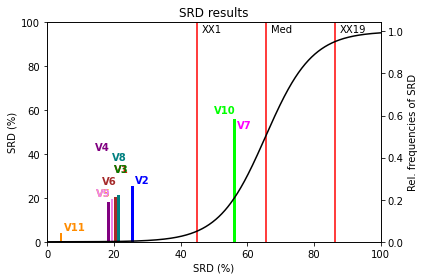

In [8]:
# SRD plot - distance from origin (and column height) means distance from the reference - the smaller the better

# This module is highly recommended for automatically adjusting the text positions
# on the SRD plot - so that it is less cluttered. Can be installed from: https://github.com/Phlya/adjustText
try:
    from adjustText import adjust_text
except ModuleNotFoundError:
    pass


fig, ax = plt.subplots()

my_colors = ['red','blue','green','purple','orange','brown','magenta','teal','violet','lime',
            'darkorange', 'darkorchid', 'darkred', 'darkseagreen', 'darkslateblue',
             'darkslategrey', 'darkturquoise', 'darkviolet','indianred', 'indigo','black']
bars=ax.bar(srd_values, srd_values, color=my_colors)

ax.set_xlim(left=0,right=100)
ax.set_ylim(bottom=0,top=100)

texts=[]
for j,rect in enumerate(bars):
    left = rect.get_x()+1
    top = rect.get_y()+rect.get_height()
    texts.append(ax.text(left,top,'%s'% srd_values.index[j],
                         color = rect.get_facecolor(), fontweight='semibold'))

try:    
    adjust_text(texts, add_objects=bars, autoalign=True, force_objects=(0.1,1.0), 
                only_move={'points':'xy', 'text':'y', 'objects':'xy'}, ha='center', va='bottom')
except NameError:
    pass

# Calculate distribution of random SRD values and significant points

[x,y,XX1,Med,XX19] = srd.crrn(len(df))

if XX1:
    ax.vlines(XX1,0,100,label='XX1',color='red')
    ax.annotate('XX1', xy=(XX1, 100), xytext=(5, -10), textcoords="offset points")
if Med:
    ax.vlines(Med,0,100,label='Med',color='red')
    ax.annotate('Med', xy=(Med, 100), xytext=(5, -10), textcoords="offset points")
if XX19:
    ax.vlines(XX19,0,100,label='XX19',color='red')
    ax.annotate('XX19', xy=(XX19, 100), xytext=(5, -10), textcoords="offset points")

ax2 = ax.twinx()
ax2.plot(x,y,color='black')
ax2.set_ylabel('Rel. frequencies of SRD')
ax2.set_ylim(bottom=0)

ax.set_title('SRD results')
ax.set_xlabel('SRD (%)')
ax.set_ylabel('SRD (%)')

fig.tight_layout()
plt.savefig('srd_plot.png',dpi=300,bbox_inches='tight')

In [3]:
# Leave-one-out cross-validation. Recommended for <14 samples

ref='mean'

cv_iterator=sklm.LeaveOneOut()
srd_collector=[]
for train_index,test_index in cv_iterator.split(df):
    srd_current=srd.srd_core(df.iloc[train_index],ref)
    srd_collector.append(srd_current)
    
srd_collector=pd.DataFrame(srd_collector)

srd_collector

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
0,20.238095,25.000000,20.238095,17.857143,16.666667,20.238095,57.142857,22.619048,20.238095,55.952381,4.761905
1,22.619048,25.000000,21.428571,21.428571,21.428571,21.428571,53.571429,20.238095,20.238095,59.523810,4.761905
2,20.238095,28.571429,20.238095,19.047619,20.238095,23.809524,60.714286,25.000000,20.238095,52.380952,4.761905
3,20.238095,29.761905,22.619048,20.238095,22.619048,23.809524,47.619048,25.000000,22.619048,52.380952,4.761905
4,21.428571,25.000000,19.047619,20.238095,20.238095,19.047619,59.523810,20.238095,17.857143,50.000000,2.380952
5,17.857143,20.238095,16.666667,15.476190,16.666667,17.857143,54.761905,15.476190,17.857143,59.523810,1.190476
6,21.428571,25.000000,20.238095,20.238095,22.619048,19.047619,59.523810,20.238095,17.857143,59.523810,2.380952
7,9.523810,15.476190,13.095238,14.285714,14.285714,10.714286,58.333333,10.714286,9.523810,55.952381,4.761905
8,20.238095,25.000000,20.238095,19.047619,17.857143,19.047619,57.142857,22.619048,20.238095,59.523810,4.761905
9,20.238095,29.761905,21.428571,20.238095,22.619048,23.809524,63.095238,25.000000,22.619048,58.333333,4.761905


In [4]:
# N-fold cross-validation. Recommended for >13 samples

ref='mean'

cv_iterator=sklm.KFold(n_splits=5)
srd_collector=[]
for train_index,test_index in cv_iterator.split(df):
    srd_current=srd.srd_core(df.iloc[train_index],ref)
    srd_collector.append(srd_current)
    
srd_collector=pd.DataFrame(srd_collector)

srd_collector

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
0,25.000000,26.666667,23.333333,21.666667,18.333333,25.000000,58.333333,25.000000,21.666667,56.666667,6.666667
1,20.000000,25.000000,18.333333,18.333333,20.000000,21.666667,48.333333,18.333333,21.666667,48.333333,0.000000
2,8.333333,15.000000,11.666667,15.000000,13.333333,6.666667,63.333333,11.666667,10.000000,63.333333,3.333333
3,18.333333,35.000000,20.000000,15.000000,16.666667,28.333333,63.333333,33.333333,26.666667,53.333333,6.666667
4,23.611111,27.777778,22.222222,22.222222,22.222222,23.611111,50.000000,23.611111,23.611111,61.111111,5.555556


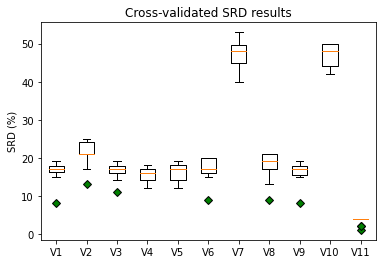

In [24]:
# Box-and-whisker plot of cross-validated SRD values

fig, ax = plt.subplots()

green_diamond = dict(markerfacecolor='g', marker='D')
ax.boxplot(np.array(srd_collector),labels=srd_collector.columns, flierprops=green_diamond)

ax.set_title('Cross-validated SRD results')
plt.ylabel('SRD (%)')

plt.savefig('bw_plot.png',dpi=300,bbox_inches='tight')
plt.show()

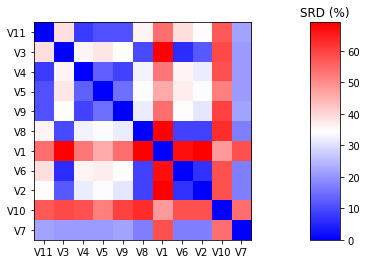

In [141]:
# Heatmap with COVAT (Comparison with One Variable at a Time). Takes each column in turn
# as the reference vector and presents the results in a heatmap format

srd_collector=[]
for ref in df.columns:
    srd_current=srd.srd_core(df,ref)
    srd_collector.append(srd_current)

srd_collector=pd.DataFrame(srd_collector)
srd_collector.index=srd_collector.columns

gs = plt.GridSpec(1, 2, width_ratios=(9, 1))

# main graph
axes = plt.subplot(gs[0,0])

# reorder columns (and rows) by average SRD
a=srd_collector.mean().rank(method='first')
i=a.sort_values().index
srd_collector.columns=i
srd_collector.index=i

pc = plt.imshow(srd_collector, cmap='bwr')

axes.set_xticks(np.arange(len(srd_collector)))
axes.set_yticks(np.arange(len(srd_collector)))
axes.set_xticklabels(srd_collector.columns)
axes.set_yticklabels(srd_collector.columns)

# colorbar
axes = plt.subplot(gs[0,1])
plt.colorbar(pc, cax=axes)
plt.title('SRD (%)')

plt.savefig('heatmap.png',dpi=300,bbox_inches='tight')